In [92]:
### IMPORTS ###
import os
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter

In [93]:
### SETTINGS ###
np.set_printoptions(precision=3, suppress=True, threshold=np.inf)

In [94]:
### FOLDER SETTINGS ###
input_folder = "../output/"

u_solution_path = input_folder + "/u_solution.dat"
v_solution_path = input_folder + "/v_solution.dat"
p_solution_path = input_folder + "/p_solution.dat"

In [95]:
format_string = '<d'  # '<d' for little-endian, '>d' for big-endian

In [96]:
with open(u_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    u_approximate_solution = data

with open(v_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    v_approximate_solution = data

with open(p_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    p_approximate_solution = data

u_approximate_solution = np.array(u_approximate_solution)    
v_approximate_solution = np.array(v_approximate_solution)
p_approximate_solution = np.array(p_approximate_solution)

In [97]:
### PARAMETERS ###

# Grid parameters
ndims = 2
num_data_per_elements = 1

sigma_grid = 64
x_grid = 64

sigma_ghost_points = 2
x_ghost_points = 2

# Physical parameters
g = 9.81

Lx = 31.0
Ls = 1.0

t = 0
kh = 1.0
lwave = Lx
kwave = 2 * np.pi / lwave
hd = kh/kwave
cwave = np.sqrt(g/kwave*np.tanh(kh))
Twave = lwave/cwave
wwave = 2 * np.pi / Twave
Hwave = 0.02

domain_begin_array = np.array([0.0, 0.0])
domain_end_array = np.array([Ls, Lx])

In [98]:
u_layout = (sigma_grid, x_grid+x_ghost_points, num_data_per_elements)
v_layout = (sigma_grid, x_grid+x_ghost_points, num_data_per_elements)
p_layout = (sigma_grid+sigma_ghost_points, x_grid+x_ghost_points, num_data_per_elements)

print("u_layout: ", u_layout)
print("v_layout: ", v_layout)
print("p_layout: ", p_layout)

u_layout:  (64, 66, 1)
v_layout:  (64, 66, 1)
p_layout:  (66, 66, 1)


In [99]:
sigma = np.linspace(domain_begin_array[0], domain_end_array[0], sigma_grid)
x = np.linspace(domain_begin_array[1], domain_end_array[1], x_grid)
SIGMA, X = np.meshgrid(sigma, x)

In [100]:
# Reshape the data into a 2D array
u_approximate_solution = u_approximate_solution.reshape(u_layout)
v_approximate_solution = v_approximate_solution.reshape(v_layout)
p_approximate_solution = p_approximate_solution.reshape(p_layout)

u_approximate_solution = np.squeeze(u_approximate_solution)
v_approximate_solution = np.squeeze(v_approximate_solution)
p_approximate_solution = np.squeeze(p_approximate_solution)

u_approximate_solution = u_approximate_solution[0:sigma_grid, 1:x_grid+1]
v_approximate_solution = v_approximate_solution[0:sigma_grid, 1:x_grid+1]
p_approximate_solution = p_approximate_solution[1:sigma_grid+1, 1:x_grid+1]

print("u_approximate_solution.shape: ", u_approximate_solution.shape)
print("v_approximate_solution.shape: ", v_approximate_solution.shape)
print("p_approximate_solution.shape: ", p_approximate_solution.shape)

u_approximate_solution.shape:  (64, 64)
v_approximate_solution.shape:  (64, 64)
p_approximate_solution.shape:  (64, 64)


In [101]:
def traveling_wave_1d(H, c, k, sigma, h_small, w, t, x):

    z = sigma*h_small - h_small

    # Compute analytical solution at level z
    uu = k * H * c / 2 * np.cosh(k * (z + h_small)) / np.sinh(k * h_small) * np.cos(w * t - k * x)
    ww = -k * H * c / 2 * np.sinh(k * (z + h_small)) / np.sinh(k * h_small) * np.sin(w * t - k * x)
    eta = H / 2 * np.cos(w * t - k * x)  # z = 0
    etax = k * H / 2 * np.sin(w * t - k * x)
    etaxx = -(k**2) * H / 2 * np.cos(w * t - k * x)
    pp = -H * c / 2 * np.cosh(k * (z + h_small)) / np.sinh(k * h_small) * np.sin(w * t - k * x)  # see p. 83 in Svendsen & Jonsson (2001)
    
    return uu, ww, eta, etax, etaxx, pp

In [102]:
# Plotting each component at t = 0
t = 0
uu, ww, eta, etax, etaxx, pp = traveling_wave_1d(Hwave, cwave, kwave, SIGMA, hd, wwave, t, X)

In [103]:
# Calculate the L2 error of the pressure
def calculate_L2_error(p, p_analytical):
    error = np.sqrt(np.sum((p - p_analytical)**2) / np.sum(p_analytical**2))
    return error

pp_error = calculate_L2_error(p_approximate_solution, pp)

print("pp_error: ", '{:.3e}'.format(pp_error/(sigma_grid*x_grid)))

# N, S, E
# 8x8, 3, 1.941e-02
# 16x16, 3, 5.078e-03
# 32x32, 3, 1.310e-03
# 64x64, 3, 3.328e-04
# 128x128, 3, 8.384e-05

# 8x8, 5, 3.896e-01
# 16x16, 5, 1.390e-02
# 32x32, 5, 1.284e-03
# 64x64, 5, 3.261e-04
# 128x128, 5, 8.199e-05


pp_error:  3.327e-04


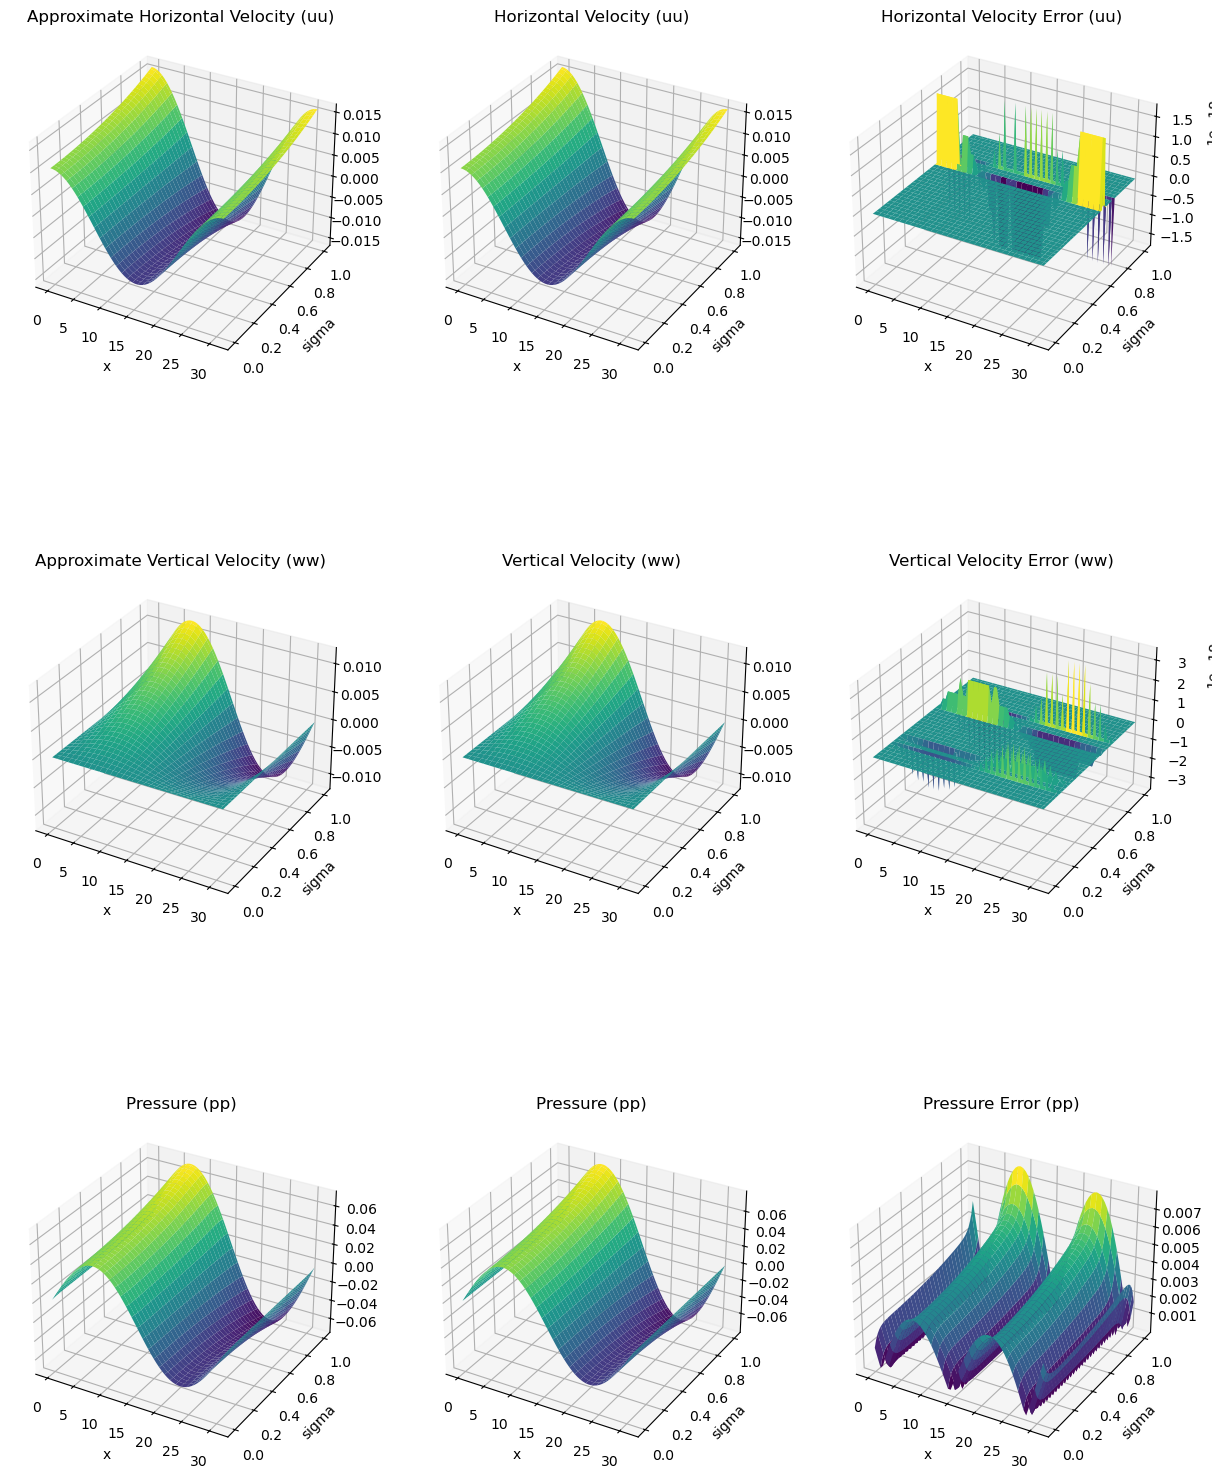

In [104]:
# Create the figure for 3D surface plots
fig = plt.figure(figsize=(15, 20))

# First Row: uu plots
# Plot Approximate Horizontal Velocity (uu)
ax1 = fig.add_subplot(3, 3, 1, projection='3d')
ax1.plot_surface(X, SIGMA, u_approximate_solution.T, cmap='viridis')
ax1.set_title('Approximate Horizontal Velocity (uu)')
ax1.set_xlabel('x')
ax1.set_ylabel('sigma')

# Plot Horizontal Velocity (uu)
ax4 = fig.add_subplot(3, 3, 2, projection='3d')
ax4.plot_surface(X, SIGMA, uu, cmap='viridis')
ax4.set_title('Horizontal Velocity (uu)')
ax4.set_xlabel('x')
ax4.set_ylabel('sigma')

# Plot Horizontal Velocity Error
ax7 = fig.add_subplot(3, 3, 3, projection='3d')
ax7.plot_surface(X, SIGMA, u_approximate_solution.T - uu, cmap='viridis')
ax7.set_title('Horizontal Velocity Error (uu)')
ax7.set_xlabel('x')
ax7.set_ylabel('sigma')

# Second Row: ww plots
# Plot Approximate Vertical Velocity (ww)
ax2 = fig.add_subplot(3, 3, 4, projection='3d')
ax2.plot_surface(X, SIGMA, v_approximate_solution.T, cmap='viridis')
ax2.set_title('Approximate Vertical Velocity (ww)')
ax2.set_xlabel('x')
ax2.set_ylabel('sigma')

# Plot Vertical Velocity (ww)
ax5 = fig.add_subplot(3, 3, 5, projection='3d')
ax5.plot_surface(X, SIGMA, ww, cmap='viridis')
ax5.set_title('Vertical Velocity (ww)')
ax5.set_xlabel('x')
ax5.set_ylabel('sigma')

# Plot Vertical Velocity Error
ax8 = fig.add_subplot(3, 3, 6, projection='3d')
ax8.plot_surface(X, SIGMA, v_approximate_solution.T - ww, cmap='viridis')
ax8.set_title('Vertical Velocity Error (ww)')
ax8.set_xlabel('x')
ax8.set_ylabel('sigma')

# Third Row: pp plots
# Plot Approximate Pressure (pp)
ax3 = fig.add_subplot(3, 3, 7, projection='3d')
ax3.plot_surface(X, SIGMA, p_approximate_solution.T, cmap='viridis')
ax3.set_title('Pressure (pp)')
ax3.set_xlabel('x')
ax3.set_ylabel('sigma')

# Plot Pressure (pp)
ax6 = fig.add_subplot(3, 3, 8, projection='3d')
ax6.plot_surface(X, SIGMA, pp, cmap='viridis')
ax6.set_title('Pressure (pp)')
ax6.set_xlabel('x')
ax6.set_ylabel('sigma')

# Plot Pressure Error
ax9 = fig.add_subplot(3, 3, 9, projection='3d')
ax9.plot_surface(X, SIGMA, np.abs(p_approximate_solution.T - pp), cmap='viridis')
ax9.set_title('Pressure Error (pp)')
ax9.set_xlabel('x')
ax9.set_ylabel('sigma')

# Adjust the spacing between the plots
#plt.subplots_adjust(wspace=1, hspace=1)
#plt.tight_layout()
plt.show()
